In [1]:
import librosa
import librosa.feature
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical

In [2]:
def display_mfcc(song):
    y, _ = librosa.load(song)
    mfcc = librosa.feature.mfcc(y)
    
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(song)
    plt.tight_layout()
    plt.show()

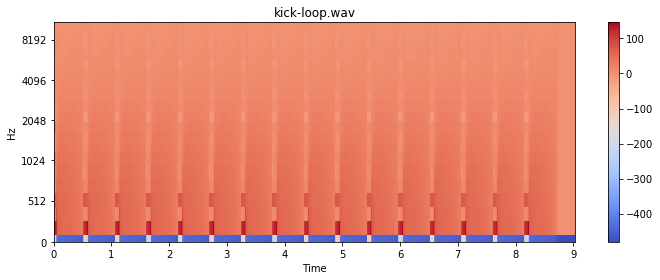

In [4]:
display_mfcc('kick-loop.wav')

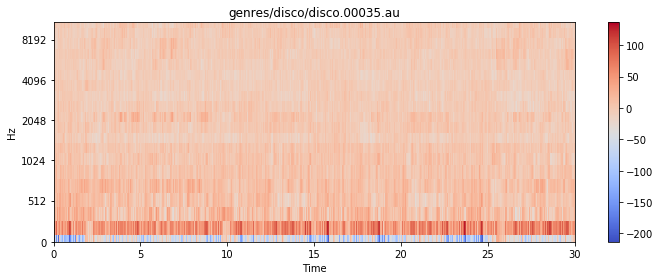

In [5]:
display_mfcc('genres/disco/disco.00035.au')

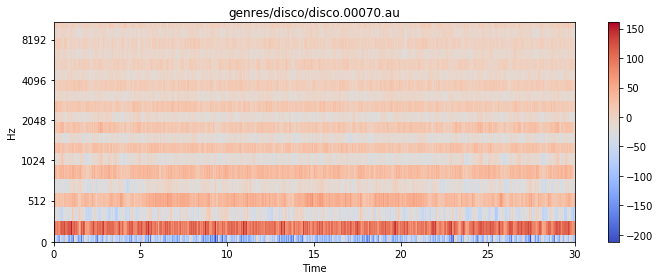

In [6]:
display_mfcc('genres/disco/disco.00070.au')

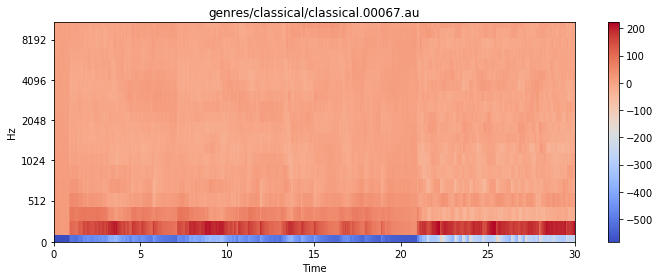

In [7]:
display_mfcc('genres/classical/classical.00067.au')

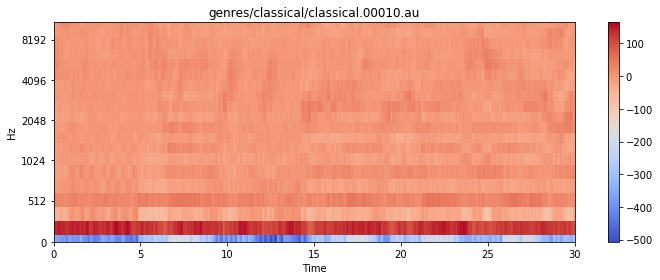

In [8]:
display_mfcc('genres/classical/classical.00010.au')

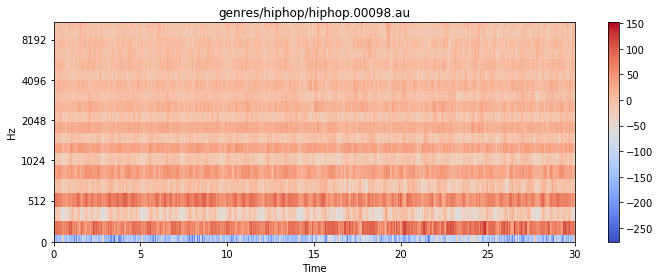

In [10]:
display_mfcc('genres/hiphop/hiphop.00098.au')

In [11]:
def extract_features_song(f):
    y, _ = librosa.load(f)
    
    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y)
    # normalize values between -1,1 (divide by max)
    mfcc /= np.max(np.absolute(mfcc))
    
    return np.ndarray.flatten(mfcc)[:25000]

In [15]:
def generate_features_and_labels():
    all_features = []
    all_labels = []
    
    genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
    for genre in genres:
        sound_files = glob.glob('genres/'+genre+'/*.au')
        print('Processing %d songs in %s genres...' % (len(sound_files),genre))
        for f in sound_files:
            features = extract_features_song(f)
            all_features.append(features)
            all_labels.append(genre)
        
    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), onehot_labels

In [16]:
features, labels = generate_features_and_labels()

Processing 100 songs in blues genres...
Processing 100 songs in classical genres...
Processing 100 songs in country genres...
Processing 100 songs in disco genres...
Processing 100 songs in hiphop genres...
Processing 100 songs in jazz genres...
Processing 100 songs in metal genres...
Processing 100 songs in pop genres...
Processing 100 songs in reggae genres...
Processing 100 songs in rock genres...


In [17]:
print(np.shape(features))
print(np.shape(labels))

training_split = 0.8

# Last column has genre, turn it into unique ids
alldata = np.column_stack((features, labels))

np.random.shuffle(alldata)
splitidx = int(len(alldata)*training_split)
train, test = alldata[:splitidx,:], alldata[splitidx:,:]

print(np.shape(train))
print(np.shape(test))

train_input = train[:,:-10]
train_labels = train[:,-10:]

test_input = test[:,:-10]
test_labels = test[:,-10:]

print(np.shape(train_input))
print(np.shape(train_labels))

(1000, 25000)
(1000, 10)
(800, 25010)
(200, 25010)
(800, 25000)
(800, 10)


In [19]:
model = Sequential([
    Dense(100, input_dim=np.shape(train_input)[1]),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
])

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
print(model.summary())

model.fit(train_input, train_labels, epochs=10, batch_size=32,
         validation_split=0.2)

loss, acc = model.evaluate(test_input, test_labels, batch_size=32)

print('Done!')
print('Loss: %.4f, accuracy: %.4f' % (loss, acc))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               2500100   
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
Total params: 2,501,110
Trainable params: 2,501,110
Non-trainable params: 0
_________________________________________________________________
None
Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 3s 4ms/step - loss: 2.3017 - acc: 0.2812 - val_loss: 1.8441 - val_acc: 0.3875
Epoch 2/10
640/640 [==============================] - 2s 2ms/step - loss: 1.5015 